# Phase space tomography

Primer for using phase space tomography tool

In [75]:
%load_ext autoreload
from preprocess import Preprocess
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tomo_plot import Plot
from reconstruct import Reconstruct, nn_predict
from track import Lattice, Model, Track
import utils


import pickle
plt.rcParams['image.cmap'] = 'jet'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import sinograms measured in AWAKE. 

In [76]:

with open('my_sinox', 'rb') as f:
    data = pickle.load(f)

projectionsx = data['sinogram']
ksx = data['ks']

with open('my_sinoy', 'rb') as f:
    data = pickle.load(f)

projectionsy = data['sinogram']
ksy = data['ks']

# with open('input_data', 'rb') as f:
#     data = pickle.load(f)
sequence = {'quad':[0.0708,10], 'drift':[0.831693]}

# beam = data['beam']
# projectionsy = data['sino_y'].T
# projectionsx = data['sino_x'].T
# ksx = data['ksx']
# ksy = data['ksy'] 



Now it is time to preprocess the data to make them ready for tomography

In [77]:
%autoreload
sequence = {'quad':[0.0708,10], 'drift':[0.831693]}

processx = Preprocess(projectionsx, ksx, sequence, plane='x', norm=[0.7, 1.5])
processy = Preprocess(projectionsy, ksy, sequence, plane='y', norm=[0.7, 1.5])


the process instance is used as input for reconstruction

In [78]:
%autoreload
recx = Reconstruct(processx)
recy = Reconstruct(processy)

dist_x = recx.MLEM(200)
dist_y = recy.MLEM(200)




c:\Users\vbencini\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


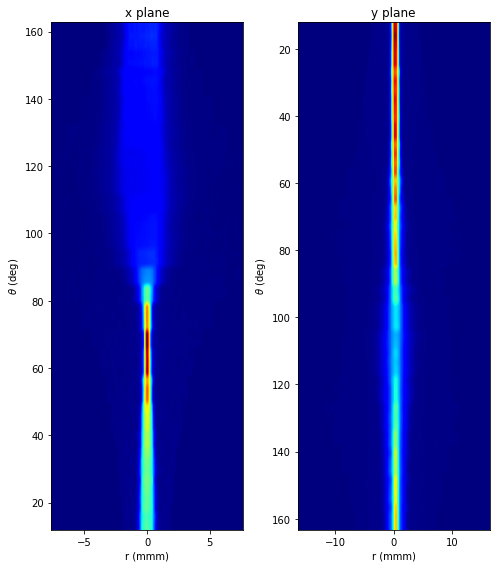

(<Figure size 504x576 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'x plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>,
        <AxesSubplot:title={'center':'y plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>], dtype=object))

In [79]:
%autoreload
pl = Plot(processx, processy, dist_x, dist_y)
# Plot scaled sinograms

pl.plot_sino_scale()


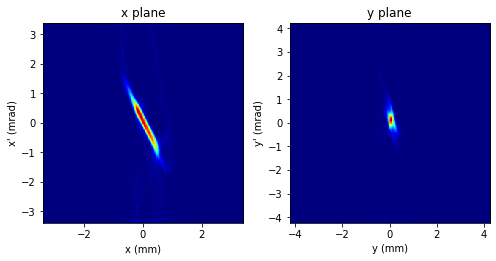

(<Figure size 504x576 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'x plane'}, xlabel='x (mm)', ylabel="x' (mrad)">,
        <AxesSubplot:title={'center':'y plane'}, xlabel='y (mm)', ylabel="y' (mrad)">], dtype=object))

In [80]:
pl.plot_reconstructed()


Let's generate a distribution from the reconstructed images

In [81]:
import importlib

i=0
x_edges = processx.x_new

# np.random.normal(x_edges[i], (x_edges[i+1]-x_edges[i])/2, 10000)

n_points = 100000
hist = dist_x

new_data = []
# for i in range(hist.shape[0]-1):
#     for j in range(hist.shape[1]-1):
#         num_points = int(hist[i,j] * n_points) # Generate 100 points in total
#         if num_points<0:
            


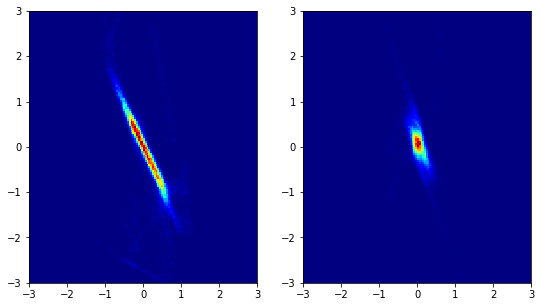

In [82]:
dist_x_part = utils.gen_dist(dist_x, 10000, processx.x_new)
dist_y_part = utils.gen_dist(dist_y, 10000, processy.x_new)



dist_x_part_unnorm = utils.apply(processx.Vi,dist_x_part)
dist_y_part_unnorm = utils.apply(processy.Vi,dist_y_part)

dist = np.hstack((dist_x_part_unnorm, dist_y_part_unnorm))

fig, axs = plt.subplots(1, 2, figsize= (9, 5))
_ = axs[0].hist2d(dist[:,0], dist[:,1], bins = 128, range=[[-3, 3],[-3, 3]])
_ = axs[1].hist2d(dist[:,2], dist[:,3], bins = 128, range=[[-3, 3],[-3, 3]])


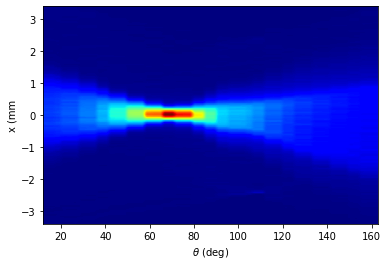

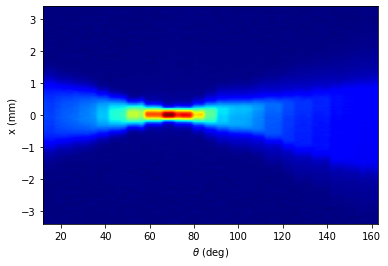

In [83]:
projections,_ = utils.track(dist_x_part_unnorm, processx.thetas, 'x', processx.x_new, processx.Vi, n_bins=128)
# projections,_ = utils.track(gen_d, processx.thetas, 'x', processx.x_new, processx.Vi, n_bins=128)
proj_trackx = utils.norm_image(projections)
plt.imshow(proj_trackx, origin = 'lower',extent=[processx.thetas[0], processx.thetas[-1], processx.x_new[0], processx.x_new[-1]],  aspect = 'auto', vmax=1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm')


plt.figure()
# plt.imshow(np.array(projections), origin = 'lower',extent=[thetas[0], thetas[-1], x[0], x[-1]],  aspect = 'auto', vmax=1)
plt.imshow(utils.norm_image(processx.unscaled_projections).T, origin = 'lower',extent=[processx.thetas[0], processx.thetas[-1], processx.x_new[0], processx.x_new[-1]],  aspect = 'auto', vmax = 1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm)')


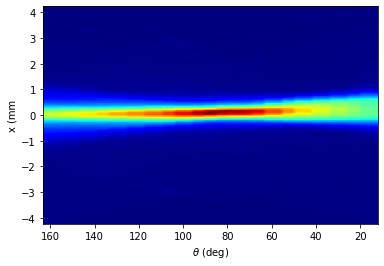

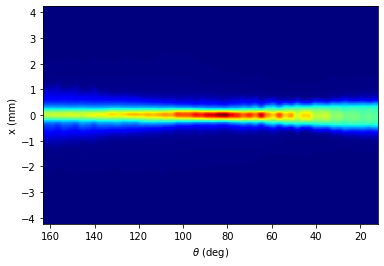

In [84]:
projections,_ = utils.track(dist_y_part_unnorm, processy.thetas, 'y', processy.x_new, processy.Vi, n_bins=128)
proj_tracky = utils.norm_image(projections)
plt.imshow(proj_tracky, origin = 'lower',extent=[processy.thetas[0], processy.thetas[-1], processy.x_new[0], processy.x_new[-1]],  aspect = 'auto', vmax=1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm')
plt.savefig('proj_track_x.png', dpi=300)

plt.figure()
# plt.imshow(np.array(projections), origin = 'lower',extent=[thetas[0], thetas[-1], x[0], x[-1]],  aspect = 'auto', vmax=1)
plt.imshow(utils.norm_image(processy.unscaled_projections).T, origin = 'lower',extent=[processy.thetas[0], processy.thetas[-1], processy.x_new[0], processy.x_new[-1]],  aspect = 'auto', vmax = 1)
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('x (mm)')
plt.savefig('proj_orig_x.png', dpi=300)

# Compare reconstruction methods

In [85]:
%autoreload
twiss_qs_x = recx.QuadScanRec()
twiss_qs_y = recy.QuadScanRec()

covx = twiss_qs_x[0]*np.array([[twiss_qs_x[2], -twiss_qs_x[1]],[-twiss_qs_x[1], twiss_qs_x[3]]])
covy = twiss_qs_y[0]*np.array([[twiss_qs_y[2], -twiss_qs_y[1]],[-twiss_qs_y[1], twiss_qs_y[3]]])
# Generate distribution with same Twiss parameters
dist_qs_x = np.random.multivariate_normal((0,0), covx, size=10000)
dist_qs_y = np.random.multivariate_normal((0,0), covy, size=10000)

dist_qs = np.hstack((dist_qs_x, dist_qs_y))
twiss_qs_y

<ipython-input-85-fba6b3538bb3>:8: RuntimeWarning: covariance is not positive-semidefinite.
  dist_qs_x = np.random.multivariate_normal((0,0), covx, size=10000)


(0.033422856734764583,
 0.82234044249173854,
 0.56211420210667096,
 2.9820342504696447)

In [86]:
%autoreload
# utils.get_twiss(dist_qs_x[:,0], dist_qs_x[:,1])
utils.get_twiss(dist_x_part_unnorm[:,0], dist_x_part_unnorm[:,1])

(0.2544787526125119,
 1.2171106347936298,
 0.75051746860287749,
 3.3061965925282384)

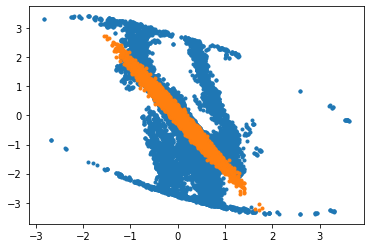

In [154]:
plt.plot(dist_x_part_unnorm[:,0], dist_x_part_unnorm[:,1],'.')
plt.plot(dist_qs_x[:,0], dist_qs_x[:,1], '.')

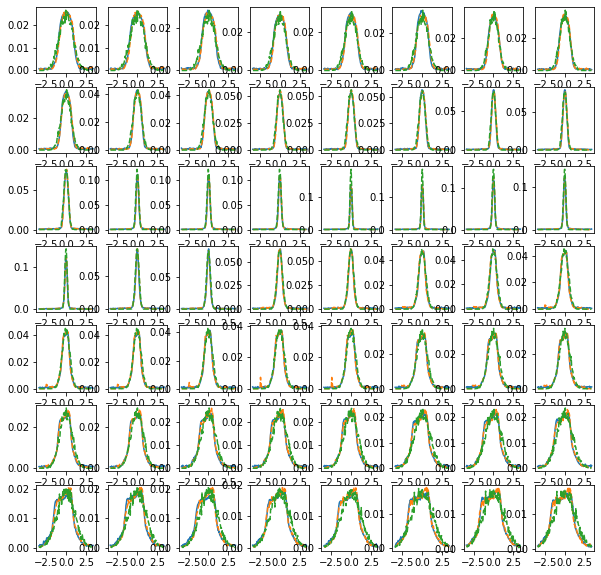

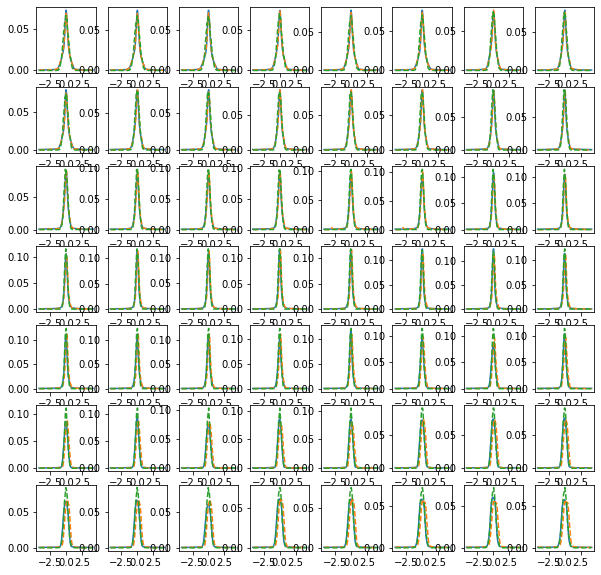

In [88]:
# ph = utils.get_theta_norm(Vi, k, 'x')
%autoreload
figx, axsx = plt.subplots(7,8, figsize = (10, 10))
figy, axsy = plt.subplots(7,8, figsize = (10, 10))
sigmasg_x = []
sigmasg_y = []
sigmas_rec_x = []
sigmas_rec_y = []
axsx = axsx.flatten()[:56]
axsy = axsy.flatten()[:56]

for p in range(56):
    ind = p
    seq = {'quad':[0.0708,recx.ks[ind]], 'drift':[0.831693]}
    tr = Track(seq, dist)
    tr.track()
    dist_out = tr.dist_out
    tr.dist = dist_qs
    tr.track()
    dist_qs_out = tr.dist_out

    projectionx, edgesx = np.histogram(dist_out[:,0], range=(processx.x_new[0], processx.x_new[-1]), bins=128)
    projectiongx, edgesgx = np.histogram(dist_qs_out[:,0], range=(processx.x_new[0], processx.x_new[-1]), bins=128)
    projectionx = projectionx/np.sum(projectionx)
    projectiongx = projectiongx/np.sum(projectiongx)

    projectiony, edgesy = np.histogram(dist_out[:,2], range=(processy.x_new[0], processy.x_new[-1]), bins=128)
    projectiongy, edgesgy = np.histogram(dist_qs_out[:,2], range=(processy.x_new[0], processy.x_new[-1]), bins=128)
    projectiony = projectiony/np.sum(projectiony)
    projectiongy = projectiongy/np.sum(projectiongy)

    axsx[p].plot(processx.x_new, processx.unscaled_projections[ind,:]/np.sum(processx.unscaled_projections[ind,:]))
    axsx[p].plot(utils.get_bin_centers(edgesx), projectionx, linestyle = '--')
    axsx[p].plot(utils.get_bin_centers(edgesgx), projectiongx, linestyle = '--')

    axsy[p].plot(processy.x_new, processy.unscaled_projections[ind,:]/np.sum(processy.unscaled_projections[ind,:]))
    axsy[p].plot(utils.get_bin_centers(edgesy), projectiony, linestyle = '--')
    axsy[p].plot(utils.get_bin_centers(edgesgy), projectiongy, linestyle = '--')

    coeffsx,_ = utils.gaussian_profile_fit(utils.get_bin_centers(edgesx), projectionx)
    sigmas_rec_x.append(coeffsx[2])
    sigmasg_x.append(np.std(dist_qs_out[:,0]))
    coeffsy,_ = utils.gaussian_profile_fit(utils.get_bin_centers(edgesy), projectiony)
    sigmas_rec_y.append(coeffsy[2])
    sigmasg_y.append(np.std(dist_qs_out[:,2]))


# figx.tight_layout()
# plt.plot(processx.x_new, processx.unscaled_projections[5,:])
# plt.plot(processx.x_new, processx.unscaled_projections[10,:])

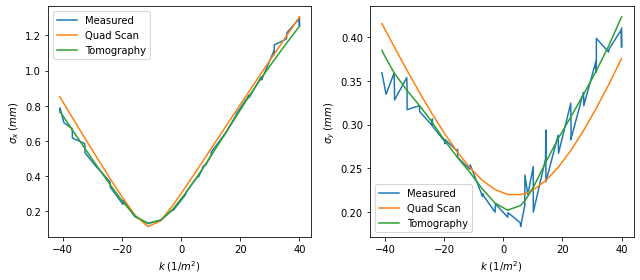

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
axs[0].plot(recx.ks, recx.sigmas, label = 'Measured')
axs[0].plot(recx.ks, np.array(sigmasg_x), label='Quad Scan')
axs[0].plot(recx.ks, np.array(sigmas_rec_x), label='Tomography')
axs[0].set_xlabel('$k$ $(1/m^2)$')
axs[0].set_ylabel('$\sigma_x$ $(mm)$')
axs[1].plot(recx.ks, recy.sigmas, label = 'Measured')
axs[1].plot(recx.ks, np.array(sigmasg_y), label='Quad Scan')
axs[1].plot(recx.ks, np.array(sigmas_rec_y), label='Tomography')
axs[1].set_xlabel('$k$ $(1/m^2)$')
axs[1].set_ylabel('$\sigma_y$ $(mm)$')
axs[0].legend()
axs[1].legend()
plt.tight_layout()

# Neural Network

To use the LSTM enhanced model, we need first to interpolate the sinograms to have 5 degrees steps.

In [144]:
%autoreload

# processx = Preprocess(projectionsx, ksx, sequence, plane='x', norm=[0.7, 1.5])
nnx = nn_predict(projectionsx, ksx, sequence, plane='x', norm=[0.4, 0.6])
nny = nn_predict(projectionsy, ksy, sequence, plane='y', norm=[0.4, 0.6])

nnx.nn_fit()
nny.nn_fit()
nnx.process.align_sinogram()
nny.process.align_sinogram()

nn_processx = nnx.process
nn_processy = nny.process
# nn.process.projections = nn.process.projections[:,3]



c:\Users\vbencini\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


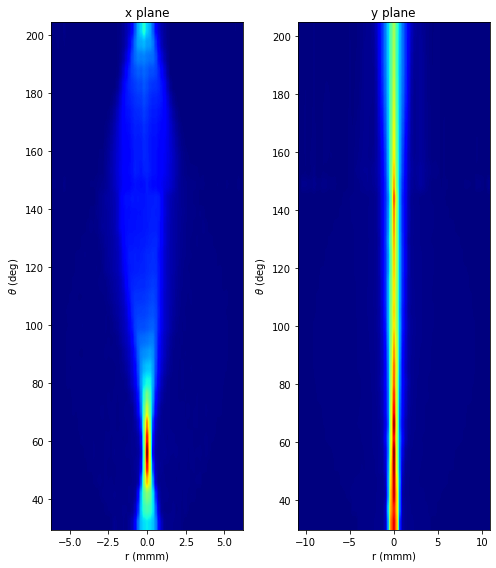

(<Figure size 504x576 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'x plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>,
        <AxesSubplot:title={'center':'y plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>], dtype=object))

In [153]:
recx_nn = Reconstruct(nn_processx)
recy_nn = Reconstruct(nn_processy)
dist_nn_x = recx_nn.MLEM(100)
dist_nn_y = recy_nn.MLEM(100)

pl_nn = Plot(nn_processx, nn_processy, dist_nn_x, dist_nn_y)
# pl.plot_reconstructed()
pl.plot_sino_scale()

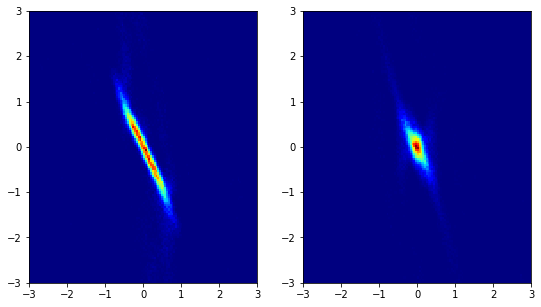

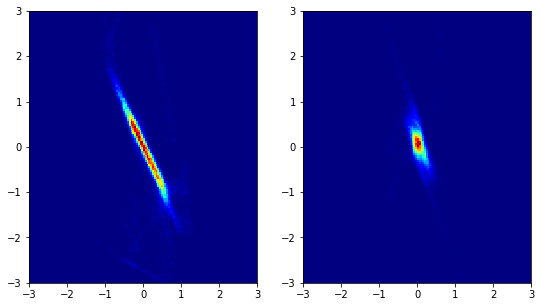

In [152]:
dist_nn_x_part = utils.gen_dist(dist_nn_x, 10000, nn_processx.x_new)
dist_nn_y_part = utils.gen_dist(dist_nn_y, 10000, nn_processy.x_new)



dist_nn_x_part_unnorm = utils.apply(nn_processx.Vi,dist_nn_x_part)
dist_nn_y_part_unnorm = utils.apply(nn_processy.Vi,dist_nn_y_part)

dist_nn = np.hstack((dist_nn_x_part_unnorm, dist_nn_y_part_unnorm))

fig, axs = plt.subplots(1, 2, figsize= (9, 5))
_ = axs[0].hist2d(dist_nn[:,0], dist_nn[:,1], bins = 128, range=[[-3, 3],[-3, 3]])
_ = axs[1].hist2d(dist_nn[:,2], dist_nn[:,3], bins = 128, range=[[-3, 3],[-3, 3]])

fig, axs = plt.subplots(1, 2, figsize= (9, 5))
_ = axs[0].hist2d(dist[:,0], dist[:,1], bins = 128, range=[[-3, 3],[-3, 3]])
_ = axs[1].hist2d(dist[:,2], dist[:,3], bins = 128, range=[[-3, 3],[-3, 3]])

In [150]:
utils.get_twiss(dist_nn_x_part_unnorm[:,0],dist_nn_x_part_unnorm[:,1])


(0.28864943712320246,
 1.1040712322012562,
 0.59822672647876063,
 3.7092513382602648)

In [151]:
utils.get_twiss(dist_x_part_unnorm[:,0],dist_x_part_unnorm[:,1])

(0.2544787526125119,
 1.2171106347936298,
 0.75051746860287749,
 3.3061965925282384)